In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
''' Choose columns to incorporate '''
#hourly_aggregated.to_csv("../data/numeric_aggregated_minute.csv",sep = ";",decimal = ".")
hourly_aggregated = pd.read_csv("../data/aggregated_numeric_data.csv",sep = ";",decimal = ".")

In [35]:
hourly_aggregated

,local_time,product_code [None],production_order_code [None],Abzug Flachlegung [mm],Abzug Zentralführung [mm],Anlage Stillstandsgrund [-],Auftrag Länge (Soll) [m],Außenluft 1 [%],Bahngeschwindigkeit [m/min],Blaskopf Zone 1 Temperatur (Soll) [°C],Blaskopf Zone 1 Temperatur [°C],Blaskopf Zone 10 Temperatur (Soll) [°C],Blaskopf Zone 10 Temperatur [°C],Blaskopf Zone 2 Temperatur (Soll) [°C],Blaskopf Zone 2 Temperatur [°C],Blaskopf Zone 3 Temperatur (Soll) [°C],Blaskopf Zone 3 Temperatur [°C],Blaskopf Zone 4 Temperatur (Soll) [°C],Blaskopf Zone 4 Temperatur [°C],Blaskopf Zone 5 Temperatur (Soll) [°C],Blaskopf Zone 5 Temperatur [°C],Blaskopf Zone 6 Temperatur (Soll) [°C],Blaskopf Zone 6 Temperatur [°C],Blaskopf Zone 7 Temperatur (Soll) [°C],Blaskopf Zone 7 Temperatur [°C],Blaskopf Zone 8 Temperatur (Soll) [°C],Blaskopf Zone 8 Temperatur [°C],Blaskopf Zone 9 Temperatur (Soll) [°C],Blaskopf Zone 9 Temperatur [°C],Breite (Soll) [mm],Breite [mm],Dickenmessung Zentrierbetrag (diagonal) [%],Dickenmessung Zentrierrichtung (diagonal) [°],Druckluftverbrauch [Nm3/h],Durchsatz (Soll) [kg/h],Durchsatz [kg/h],Elektrische Leistung Gesamt [kW],Extruder A AF1 Temperatur (Soll) [°C],Extruder A AF1 Temperatur [°C],Extruder A Dicke (Soll) [µm],Extruder A Drehzahl [1/min],Extruder A Durchsatz [kg/h],Extruder A Förderrate [kg/U/min],Extruder A HK Anteil ( Soll) [%],Extruder A HK Anteil [%],Extruder A HK Dichte [g/ccm],Extruder A HK Durchsatz [kg/h],Extruder A Laufmetergewicht [g/m],Extruder A Massedruck [bar],Extruder A Massetemperatur [°C],Extruder A Motorstrom [A],Extruder A NK 1 Anteil (Soll) [%],Extruder A NK 1 Anteil [%],Extruder A NK 1 Ausstoß maximal (Soll) [kg/h],Extruder A NK 1 Drehzahl [1/min],Extruder A NK 1 Durchsatz [kg/h],Extruder A NK 2 Anteil (Soll) [%],Extruder A NK 2 Anteil [%],Extruder A NK 2 Ausstoß maximal (Soll) [kg/h],Extruder A NK 2 Drehzahl [1/min],Extruder A NK 2 Durchsatz [kg/h],Extruder A NK 3 Anteil (Soll) [%],Extruder A NK 3 Anteil [%],Extruder A NK 3 Ausstoß maximal (Soll) [kg/h],Extruder A NK 3 Drehzahl [1/min],Extruder A NK 3 Durchsatz [kg/h],Extruder A NK 4 Anteil (Soll) [%],Extruder A NK 4 Anteil [%],Extruder A NK 4 Ausstoß maximal (Soll) [kg/h],Extruder A NK 4 Drehzahl [1/min],Extruder A NK 4 Durchsatz [kg/h],Extruder A NK 5 Anteil (Soll) [%],Extruder A NK 5 Anteil [%],Extruder A NK 5 Ausstoß maximal (Soll) [kg/h],Extruder A NK 5 Drehzahl [1/min],Extruder A NK 5 Durchsatz [kg/h],Extruder A NK1 Dichte [g/ccm],Extruder A NK1 Förderrate [kg/U/min],Extruder A NK2 Dichte [g/ccm],Extruder A NK2 Förderrate [kg/U/min],Extruder A NK3 Dichte [g/ccm],Extruder A NK3 Förderrate [kg/U/min],Extruder A NK4 Dichte [g/ccm],Extruder A NK4 Förderrate [kg/U/min],Extruder A NK5 Dichte [g/ccm],Extruder A NK5 Förderrate [kg/U/min],Extruder A Nutmutter Temperatur (Soll) [°C],Extruder A Nutmutter Temperatur [°C],Extruder A Schichtdicke [µm],Extruder A Siebwechsler Temperatur (Soll) [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur (Soll) [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur (Soll) [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur (Soll) [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur (Soll) [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur (Soll) [°C],Extruder B AF1 Temperatur [°C],Extruder B Dicke (Soll) [µm],Extruder B Drehzahl [1/min],Extruder B Durchsatz [kg/h],Extruder B Förderrate [kg/U/min],Extruder B HK Anteil (Soll) [%],Extruder B HK Anteil [%],Extruder B HK Dichte [g/ccm],Extruder B HK Durchsatz [kg/h],Extruder B Laufmetergewicht [g/m],Extruder B Massedruck [bar],Extruder B Massetemperatur [°C],Extruder B Motorstrom [A],Extruder B NK 1 Anteil (Soll) [%],Extruder B NK 1 Anteil [%],Extruder B NK 1 Ausstoß maximal (Soll) [kg/h],Extruder B NK 1 Drehzahl [1/min],Extruder B NK 1 Durchsatz [kg/h],Extruder B NK 2 Anteil (Soll) [%],Extruder B NK 2 Anteil [%],Extruder B NK 2 Ausstoß maximal (Soll) [kg/h],Extruder B NK 2 Drehzahl [1/min],

In [7]:
''' Another approach: categorize the data points with zero and one corresponding to if a quality deviation is imminent'''
# Load Failure timestamps
#failure_timestamps =  pd.read_csv("../RUL_Quality/timestamps_three_sigma.csv")
#failure_timestamps = failure_timestamps["local_time"]
failure_timestamps = ["2022-04-25","2022-05-04","2022-05-24","2022-05-29","2022-06-14"]
# 1.) Convert zero_days to datetime objects
failure_timestamps = [pd.Timestamp(day) for day in failure_timestamps]
print(failure_timestamps)

nr_of_failures = len(failure_timestamps)

# Create copy of original, aggregated data

hourly_aggregated["Date"] = pd.to_datetime(hourly_aggregated["local_time"]).dt.floor("min")

merged_data = hourly_aggregated
print(merged_data.shape)

# 2.) Calculate remaining days-hours-minutes for each row
# TODO
# uncomment depending on wished function
all_dates = pd.DataFrame()
dfs = []
for index,end_day in enumerate(failure_timestamps[:nr_of_failures-1]):
    #day_list = pd.date_range(start=zero_days[index], end=zero_days[index+1],inclusive="right").to_list()
    #hour_list = pd.date_range(start=failure_timestamps[index], end=failure_timestamps[index+1],inclusive="right",freq='H')


    minute_list = pd.date_range(start=failure_timestamps[index], end=failure_timestamps[index+1],inclusive="right",freq='min')

    minutes_before = 30
    final_minutes = len(minute_list)-minutes_before

    # Add label 0 to all "normal minutes" with no incoming failure
    zero_minutes = [0 for minute in minute_list[:final_minutes]]

    # Add label 1 to all "minutes_before" rows
    before_minutes = [1 for minute in minute_list[final_minutes:]]

    remaining_minutes = zero_minutes + before_minutes

    #print(len(remaining_minutes))
    #print(len(minute_list))

    # Replace with respective list and RUL corresponding to liens before
    df = pd.DataFrame({'Date': minute_list, 'RUL': remaining_minutes})

    dfs.append(df)

all_dates = pd.concat(dfs)
print(all_dates["RUL"].to_list())

all_dates["Date"] = pd.to_datetime(all_dates["Date"]).dt.floor("min")
all_dates["Date"].to_list()

# 3.) merge RUL table with original table, the transformation before must be done 
# to convert the Date row to the correct format
merged_data = pd.merge(merged_data,all_dates,on="Date")

print(merged_data.shape)
print(merged_data["RUL"].sum())
print(merged_data.columns)

[Timestamp('2022-04-25 00:00:00'), Timestamp('2022-05-04 00:00:00'), Timestamp('2022-05-24 00:00:00'), Timestamp('2022-05-29 00:00:00'), Timestamp('2022-06-14 00:00:00')]
(110859, 301)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

(71150, 22)
(71150, 21)


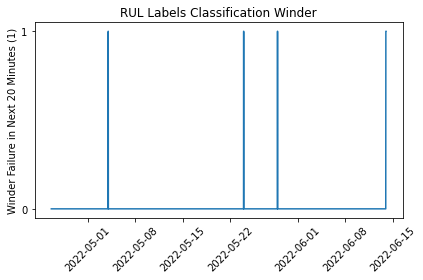

In [9]:
# Do various other transformations of the trainings data, f.I. choose only specific columns

merged_data_final = merged_data

columns_granger = pd.read_csv("cross_correlation_df.csv")
columns_granger = columns_granger["index"].to_list()
columns_granger.remove("RUL")
columns = []
#columns = [x for x in merged_data.columns if "kW" in x]
#columns = [x for x in merged_data.columns if "Extruder" in x]
#columns = columns + ["Bahngeschwindigkeit [m/min]","RUL","Date","local_time"]
'''columns = ["Druckluftverbrauch [Nm3/h]","Extruder B Motorstrom [A]","Extruder B Massedruck [bar]","Extruder B Massetemperatur [°C]",
                       "Extruder A Motorstrom [A]","Extruder A Massedruck [bar]","Extruder A Massetemperatur [°C]",
                       "Extruder C Motorstrom [A]","Extruder C Massedruck [bar]","Extruder C Massetemperatur [°C]","Leistung [kW]","Mittelwert Foliendicke [µm]","Prozessabwärme [kW]",
                       "Spezifische Energie gesamt [kWh/kg]","Wobble Median [mm]","Wärmetauscher Kühlleistung [kW]","Durchsatz [kg/h]","product_code [None]","Date","RUL"]
'''
#merged_data_final = merged_data[columns]
merged_data_final = merged_data[columns_granger[0:20] + ["RUL","Date"]]

print(merged_data_final.shape)



'''Only look at last 5hrs before spike'''
#merged_data_final = merged_data_final[merged_data_final["RUL"] <= 900]
plt.plot(merged_data["Date"],merged_data["RUL"])
plt.title("RUL Labels Classification Winder")
plt.ylabel("Winder Failure in Next 20 Minutes (1)")
plt.xticks(rotation= 45)
plt.yticks([0,1])
plt.tight_layout()
plt.savefig("rul_classification.png")
plt.show

''' Create Validation set consisting of last cycle '''
last_cycle = merged_data_final[merged_data_final["Date"] > '2022-05-29 14:00:00']
last_cycle

''' Create Train set consisting of all data before '''
first_cycles = merged_data_final[merged_data_final["Date"] <= '2022-05-29 14:00:00']
first_cycles.shape

''' Clean those datasets for training '''
#first_cycles = first_cycles.drop("local_time",axis=1)
first_cycles = first_cycles.drop("Date",axis=1)
first_cycles.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)

#last_cycle = last_cycle.drop("local_time",axis=1)
last_cycle = last_cycle.drop("Date",axis=1)
last_cycle.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)

first_cycles.shape

#merged_data_final = merged_data_final.drop("local_time",axis=1)
merged_data_final = merged_data_final.drop("Date",axis=1)
merged_data_final.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)
print(merged_data_final.shape)

In [16]:
''' RUL prediction XG Boost'''
''' 1.) Split in train and testdata'''
y = first_cycles["RUL"]
X = first_cycles.drop("RUL",axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=22)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.04],
              'max_depth': [6],
              'colsample_bytree': [0.5,0.6],
              'n_estimators': [450,500],
              'reg_lambda': [0],
             }

grid_search = GridSearchCV(
                        xgboost.XGBClassifier(),
                        parameters,
                        cv = 3,
                        refit=True, 
                        verbose=False)

%time grid_search.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train),(X_valid, y_valid)])

model = grid_search.best_estimator_
print(model)

[0]	validation_0-logloss:0.64465	validation_1-logloss:0.64471
[1]	validation_0-logloss:0.60077	validation_1-logloss:0.60086
[2]	validation_0-logloss:0.56088	validation_1-logloss:0.56101


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.52447	validation_1-logloss:0.52462
[4]	validation_0-logloss:0.49110	validation_1-logloss:0.49129
[5]	validation_0-logloss:0.46041	validation_1-logloss:0.46067
[6]	validation_0-logloss:0.43213	validation_1-logloss:0.43245
[7]	validation_0-logloss:0.40601	validation_1-logloss:0.40638
[8]	validation_0-logloss:0.38182	validation_1-logloss:0.38223
[9]	validation_0-logloss:0.35936	validation_1-logloss:0.35983
[10]	validation_0-logloss:0.33850	validation_1-logloss:0.33902
[11]	validation_0-logloss:0.31910	validation_1-logloss:0.31963
[12]	validation_0-logloss:0.30101	validation_1-logloss:0.30157
[13]	validation_0-logloss:0.28411	validation_1-logloss:0.28472
[14]	validation_0-logloss:0.26832	validation_1-logloss:0.26897
[15]	validation_0-logloss:0.25356	validation_1-logloss:0.25423
[16]	validation_0-logloss:0.23972	validation_1-logloss:0.24041
[17]	validation_0-logloss:0.22673	validation_1-logloss:0.22747
[18]	validation_0-logloss:0.21454	validation_1-logloss:0.21533

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43198	validation_1-logloss:0.43226
[7]	validation_0-logloss:0.40585	validation_1-logloss:0.40617
[8]	validation_0-logloss:0.38166	validation_1-logloss:0.38201
[9]	validation_0-logloss:0.35921	validation_1-logloss:0.35961
[10]	validation_0-logloss:0.33837	validation_1-logloss:0.33879
[11]	validation_0-logloss:0.31897	validation_1-logloss:0.31941
[12]	validation_0-logloss:0.30087	validation_1-logloss:0.30135
[13]	validation_0-logloss:0.28398	validation_1-logloss:0.28449
[14]	validation_0-logloss:0.26819	validation_1-logloss:0.26873
[15]	validation_0-logloss:0.25342	validation_1-logloss:0.25400
[16]	validation_0-logloss:0.23958	validation_1-logloss:0.24019
[17]	validation_0-logloss:0.22657	validation_1-logloss:0.22724
[18]	validation_0-logloss:0.21436	validation_1-logloss:0.21507
[19]	validation_0-logloss:0.20289	validation_1-logloss:0.20365
[20]	validation_0-logloss:0.19214	validation_1-logloss:0.19295
[21]	validation_0-logloss:0.18202	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43205	validation_1-logloss:0.43234
[7]	validation_0-logloss:0.40593	validation_1-logloss:0.40626
[8]	validation_0-logloss:0.38175	validation_1-logloss:0.38211
[9]	validation_0-logloss:0.35931	validation_1-logloss:0.35971
[10]	validation_0-logloss:0.33846	validation_1-logloss:0.33888
[11]	validation_0-logloss:0.31906	validation_1-logloss:0.31951
[12]	validation_0-logloss:0.30096	validation_1-logloss:0.30144
[13]	validation_0-logloss:0.28407	validation_1-logloss:0.28457
[14]	validation_0-logloss:0.26827	validation_1-logloss:0.26881
[15]	validation_0-logloss:0.25351	validation_1-logloss:0.25408
[16]	validation_0-logloss:0.23967	validation_1-logloss:0.24026
[17]	validation_0-logloss:0.22668	validation_1-logloss:0.22731
[18]	validation_0-logloss:0.21449	validation_1-logloss:0.21516
[19]	validation_0-logloss:0.20303	validation_1-logloss:0.20374
[20]	validation_0-logloss:0.19229	validation_1-logloss:0.19303
[21]	validation_0-logloss:0.18216	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43213	validation_1-logloss:0.43245
[7]	validation_0-logloss:0.40601	validation_1-logloss:0.40638
[8]	validation_0-logloss:0.38182	validation_1-logloss:0.38223
[9]	validation_0-logloss:0.35936	validation_1-logloss:0.35983
[10]	validation_0-logloss:0.33850	validation_1-logloss:0.33902
[11]	validation_0-logloss:0.31910	validation_1-logloss:0.31963
[12]	validation_0-logloss:0.30101	validation_1-logloss:0.30157
[13]	validation_0-logloss:0.28411	validation_1-logloss:0.28472
[14]	validation_0-logloss:0.26832	validation_1-logloss:0.26897
[15]	validation_0-logloss:0.25356	validation_1-logloss:0.25423
[16]	validation_0-logloss:0.23972	validation_1-logloss:0.24041
[17]	validation_0-logloss:0.22673	validation_1-logloss:0.22747
[18]	validation_0-logloss:0.21454	validation_1-logloss:0.21533
[19]	validation_0-logloss:0.20309	validation_1-logloss:0.20391
[20]	validation_0-logloss:0.19234	validation_1-logloss:0.19318
[21]	validation_0-logloss:0.18222	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.40585	validation_1-logloss:0.40617
[8]	validation_0-logloss:0.38166	validation_1-logloss:0.38201
[9]	validation_0-logloss:0.35921	validation_1-logloss:0.35961
[10]	validation_0-logloss:0.33837	validation_1-logloss:0.33879
[11]	validation_0-logloss:0.31897	validation_1-logloss:0.31941
[12]	validation_0-logloss:0.30087	validation_1-logloss:0.30135
[13]	validation_0-logloss:0.28398	validation_1-logloss:0.28449
[14]	validation_0-logloss:0.26819	validation_1-logloss:0.26873
[15]	validation_0-logloss:0.25342	validation_1-logloss:0.25400
[16]	validation_0-logloss:0.23958	validation_1-logloss:0.24019
[17]	validation_0-logloss:0.22657	validation_1-logloss:0.22724
[18]	validation_0-logloss:0.21436	validation_1-logloss:0.21507
[19]	validation_0-logloss:0.20289	validation_1-logloss:0.20365
[20]	validation_0-logloss:0.19214	validation_1-logloss:0.19295
[21]	validation_0-logloss:0.18202	validation_1-logloss:0.18288
[22]	validation_0-logloss:0.17250	validation_1-logloss:0.1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43205	validation_1-logloss:0.43234
[7]	validation_0-logloss:0.40593	validation_1-logloss:0.40626
[8]	validation_0-logloss:0.38175	validation_1-logloss:0.38211
[9]	validation_0-logloss:0.35931	validation_1-logloss:0.35971
[10]	validation_0-logloss:0.33846	validation_1-logloss:0.33888
[11]	validation_0-logloss:0.31906	validation_1-logloss:0.31951
[12]	validation_0-logloss:0.30096	validation_1-logloss:0.30144
[13]	validation_0-logloss:0.28407	validation_1-logloss:0.28457
[14]	validation_0-logloss:0.26827	validation_1-logloss:0.26881
[15]	validation_0-logloss:0.25351	validation_1-logloss:0.25408
[16]	validation_0-logloss:0.23967	validation_1-logloss:0.24026
[17]	validation_0-logloss:0.22668	validation_1-logloss:0.22731
[18]	validation_0-logloss:0.21449	validation_1-logloss:0.21516
[19]	validation_0-logloss:0.20303	validation_1-logloss:0.20374
[20]	validation_0-logloss:0.19229	validation_1-logloss:0.19303
[21]	validation_0-logloss:0.18216	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47306	validation_1-logloss:0.47332
[7]	validation_0-logloss:0.44954	validation_1-logloss:0.44984
[8]	validation_0-logloss:0.42748	validation_1-logloss:0.42782
[9]	validation_0-logloss:0.40674	validation_1-logloss:0.40712
[10]	validation_0-logloss:0.38725	validation_1-logloss:0.38767
[11]	validation_0-logloss:0.36891	validation_1-logloss:0.36934
[12]	validation_0-logloss:0.35161	validation_1-logloss:0.35206
[13]	validation_0-logloss:0.33528	validation_1-logloss:0.33577
[14]	validation_0-logloss:0.31985	validation_1-logloss:0.32038
[15]	validation_0-logloss:0.30527	validation_1-logloss:0.30582
[16]	validation_0-logloss:0.29147	validation_1-logloss:0.29203
[17]	validation_0-logloss:0.27838	validation_1-logloss:0.27899
[18]	validation_0-logloss:0.26597	validation_1-logloss:0.26662
[19]	validation_0-logloss:0.25420	validation_1-logloss:0.25488
[20]	validation_0-logloss:0.24305	validation_1-logloss:0.24374
[21]	validation_0-logloss:0.23244	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.44941	validation_1-logloss:0.44966
[8]	validation_0-logloss:0.42734	validation_1-logloss:0.42762
[9]	validation_0-logloss:0.40660	validation_1-logloss:0.40693
[10]	validation_0-logloss:0.38712	validation_1-logloss:0.38746
[11]	validation_0-logloss:0.36878	validation_1-logloss:0.36914
[12]	validation_0-logloss:0.35147	validation_1-logloss:0.35186
[13]	validation_0-logloss:0.33514	validation_1-logloss:0.33555
[14]	validation_0-logloss:0.31971	validation_1-logloss:0.32014
[15]	validation_0-logloss:0.30513	validation_1-logloss:0.30558
[16]	validation_0-logloss:0.29132	validation_1-logloss:0.29180
[17]	validation_0-logloss:0.27821	validation_1-logloss:0.27874
[18]	validation_0-logloss:0.26579	validation_1-logloss:0.26636
[19]	validation_0-logloss:0.25400	validation_1-logloss:0.25461
[20]	validation_0-logloss:0.24285	validation_1-logloss:0.24349
[21]	validation_0-logloss:0.23225	validation_1-logloss:0.23291
[22]	validation_0-logloss:0.22217	validation_1-logloss:0.2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47300	validation_1-logloss:0.47323
[7]	validation_0-logloss:0.44947	validation_1-logloss:0.44973
[8]	validation_0-logloss:0.42741	validation_1-logloss:0.42770
[9]	validation_0-logloss:0.40669	validation_1-logloss:0.40701
[10]	validation_0-logloss:0.38720	validation_1-logloss:0.38754
[11]	validation_0-logloss:0.36886	validation_1-logloss:0.36923
[12]	validation_0-logloss:0.35155	validation_1-logloss:0.35195
[13]	validation_0-logloss:0.33522	validation_1-logloss:0.33564
[14]	validation_0-logloss:0.31979	validation_1-logloss:0.32023
[15]	validation_0-logloss:0.30521	validation_1-logloss:0.30568
[16]	validation_0-logloss:0.29140	validation_1-logloss:0.29189
[17]	validation_0-logloss:0.27832	validation_1-logloss:0.27884
[18]	validation_0-logloss:0.26591	validation_1-logloss:0.26646
[19]	validation_0-logloss:0.25415	validation_1-logloss:0.25473
[20]	validation_0-logloss:0.24300	validation_1-logloss:0.24360
[21]	validation_0-logloss:0.23239	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47306	validation_1-logloss:0.47332
[7]	validation_0-logloss:0.44954	validation_1-logloss:0.44984
[8]	validation_0-logloss:0.42748	validation_1-logloss:0.42782
[9]	validation_0-logloss:0.40674	validation_1-logloss:0.40712
[10]	validation_0-logloss:0.38725	validation_1-logloss:0.38767
[11]	validation_0-logloss:0.36891	validation_1-logloss:0.36934
[12]	validation_0-logloss:0.35161	validation_1-logloss:0.35206
[13]	validation_0-logloss:0.33528	validation_1-logloss:0.33577
[14]	validation_0-logloss:0.31985	validation_1-logloss:0.32038
[15]	validation_0-logloss:0.30527	validation_1-logloss:0.30582
[16]	validation_0-logloss:0.29147	validation_1-logloss:0.29203
[17]	validation_0-logloss:0.27838	validation_1-logloss:0.27899
[18]	validation_0-logloss:0.26597	validation_1-logloss:0.26662
[19]	validation_0-logloss:0.25420	validation_1-logloss:0.25488
[20]	validation_0-logloss:0.24305	validation_1-logloss:0.24374
[21]	validation_0-logloss:0.23244	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.44941	validation_1-logloss:0.44966
[8]	validation_0-logloss:0.42734	validation_1-logloss:0.42762
[9]	validation_0-logloss:0.40660	validation_1-logloss:0.40693
[10]	validation_0-logloss:0.38712	validation_1-logloss:0.38746
[11]	validation_0-logloss:0.36878	validation_1-logloss:0.36914
[12]	validation_0-logloss:0.35147	validation_1-logloss:0.35186
[13]	validation_0-logloss:0.33514	validation_1-logloss:0.33555
[14]	validation_0-logloss:0.31971	validation_1-logloss:0.32014
[15]	validation_0-logloss:0.30513	validation_1-logloss:0.30558
[16]	validation_0-logloss:0.29132	validation_1-logloss:0.29180
[17]	validation_0-logloss:0.27821	validation_1-logloss:0.27874
[18]	validation_0-logloss:0.26579	validation_1-logloss:0.26636
[19]	validation_0-logloss:0.25400	validation_1-logloss:0.25461
[20]	validation_0-logloss:0.24285	validation_1-logloss:0.24349
[21]	validation_0-logloss:0.23225	validation_1-logloss:0.23291
[22]	validation_0-logloss:0.22217	validation_1-logloss:0.2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47300	validation_1-logloss:0.47323
[7]	validation_0-logloss:0.44947	validation_1-logloss:0.44973
[8]	validation_0-logloss:0.42741	validation_1-logloss:0.42770
[9]	validation_0-logloss:0.40669	validation_1-logloss:0.40701
[10]	validation_0-logloss:0.38720	validation_1-logloss:0.38754
[11]	validation_0-logloss:0.36886	validation_1-logloss:0.36923
[12]	validation_0-logloss:0.35155	validation_1-logloss:0.35195
[13]	validation_0-logloss:0.33522	validation_1-logloss:0.33564
[14]	validation_0-logloss:0.31979	validation_1-logloss:0.32023
[15]	validation_0-logloss:0.30521	validation_1-logloss:0.30568
[16]	validation_0-logloss:0.29140	validation_1-logloss:0.29189
[17]	validation_0-logloss:0.27832	validation_1-logloss:0.27884
[18]	validation_0-logloss:0.26591	validation_1-logloss:0.26646
[19]	validation_0-logloss:0.25415	validation_1-logloss:0.25473
[20]	validation_0-logloss:0.24300	validation_1-logloss:0.24360
[21]	validation_0-logloss:0.23239	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.46034	validation_1-logloss:0.46068
[6]	validation_0-logloss:0.43206	validation_1-logloss:0.43246
[7]	validation_0-logloss:0.40594	validation_1-logloss:0.40638
[8]	validation_0-logloss:0.38176	validation_1-logloss:0.38225
[9]	validation_0-logloss:0.35932	validation_1-logloss:0.35986
[10]	validation_0-logloss:0.33847	validation_1-logloss:0.33904
[11]	validation_0-logloss:0.31907	validation_1-logloss:0.31966
[12]	validation_0-logloss:0.30097	validation_1-logloss:0.30161
[13]	validation_0-logloss:0.28408	validation_1-logloss:0.28475
[14]	validation_0-logloss:0.26829	validation_1-logloss:0.26900
[15]	validation_0-logloss:0.25351	validation_1-logloss:0.25428
[16]	validation_0-logloss:0.23968	validation_1-logloss:0.24047
[17]	validation_0-logloss:0.22669	validation_1-logloss:0.22753
[18]	validation_0-logloss:0.21450	validation_1-logloss:0.21536
[19]	validation_0-logloss:0.20305	validation_1-logloss:0.20394
[20]	validation_0-logloss:0.19230	validation_1-logloss:0.193

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43198	validation_1-logloss:0.43231
[7]	validation_0-logloss:0.40583	validation_1-logloss:0.40621
[8]	validation_0-logloss:0.38164	validation_1-logloss:0.38206
[9]	validation_0-logloss:0.35920	validation_1-logloss:0.35965
[10]	validation_0-logloss:0.33835	validation_1-logloss:0.33883
[11]	validation_0-logloss:0.31895	validation_1-logloss:0.31946
[12]	validation_0-logloss:0.30086	validation_1-logloss:0.30140
[13]	validation_0-logloss:0.28396	validation_1-logloss:0.28453
[14]	validation_0-logloss:0.26817	validation_1-logloss:0.26878
[15]	validation_0-logloss:0.25340	validation_1-logloss:0.25404
[16]	validation_0-logloss:0.23956	validation_1-logloss:0.24024
[17]	validation_0-logloss:0.22655	validation_1-logloss:0.22728
[18]	validation_0-logloss:0.21437	validation_1-logloss:0.21513
[19]	validation_0-logloss:0.20291	validation_1-logloss:0.20370
[20]	validation_0-logloss:0.19216	validation_1-logloss:0.19299
[21]	validation_0-logloss:0.18204	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.46031	validation_1-logloss:0.46061
[6]	validation_0-logloss:0.43205	validation_1-logloss:0.43238
[7]	validation_0-logloss:0.40593	validation_1-logloss:0.40629
[8]	validation_0-logloss:0.38174	validation_1-logloss:0.38214
[9]	validation_0-logloss:0.35931	validation_1-logloss:0.35974
[10]	validation_0-logloss:0.33845	validation_1-logloss:0.33891
[11]	validation_0-logloss:0.31906	validation_1-logloss:0.31955
[12]	validation_0-logloss:0.30096	validation_1-logloss:0.30148
[13]	validation_0-logloss:0.28406	validation_1-logloss:0.28462
[14]	validation_0-logloss:0.26827	validation_1-logloss:0.26885
[15]	validation_0-logloss:0.25348	validation_1-logloss:0.25412
[16]	validation_0-logloss:0.23964	validation_1-logloss:0.24031
[17]	validation_0-logloss:0.22666	validation_1-logloss:0.22736
[18]	validation_0-logloss:0.21449	validation_1-logloss:0.21521
[19]	validation_0-logloss:0.20302	validation_1-logloss:0.20379
[20]	validation_0-logloss:0.19228	validation_1-logloss:0.193

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43206	validation_1-logloss:0.43246
[7]	validation_0-logloss:0.40594	validation_1-logloss:0.40638
[8]	validation_0-logloss:0.38176	validation_1-logloss:0.38225
[9]	validation_0-logloss:0.35932	validation_1-logloss:0.35986
[10]	validation_0-logloss:0.33847	validation_1-logloss:0.33904
[11]	validation_0-logloss:0.31907	validation_1-logloss:0.31966
[12]	validation_0-logloss:0.30097	validation_1-logloss:0.30161
[13]	validation_0-logloss:0.28408	validation_1-logloss:0.28475
[14]	validation_0-logloss:0.26829	validation_1-logloss:0.26900
[15]	validation_0-logloss:0.25351	validation_1-logloss:0.25428
[16]	validation_0-logloss:0.23968	validation_1-logloss:0.24047
[17]	validation_0-logloss:0.22669	validation_1-logloss:0.22753
[18]	validation_0-logloss:0.21450	validation_1-logloss:0.21536
[19]	validation_0-logloss:0.20305	validation_1-logloss:0.20394
[20]	validation_0-logloss:0.19230	validation_1-logloss:0.19320
[21]	validation_0-logloss:0.18217	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43198	validation_1-logloss:0.43231
[7]	validation_0-logloss:0.40583	validation_1-logloss:0.40621
[8]	validation_0-logloss:0.38164	validation_1-logloss:0.38206
[9]	validation_0-logloss:0.35920	validation_1-logloss:0.35965
[10]	validation_0-logloss:0.33835	validation_1-logloss:0.33883
[11]	validation_0-logloss:0.31895	validation_1-logloss:0.31946
[12]	validation_0-logloss:0.30086	validation_1-logloss:0.30140
[13]	validation_0-logloss:0.28396	validation_1-logloss:0.28453
[14]	validation_0-logloss:0.26817	validation_1-logloss:0.26878
[15]	validation_0-logloss:0.25340	validation_1-logloss:0.25404
[16]	validation_0-logloss:0.23956	validation_1-logloss:0.24024
[17]	validation_0-logloss:0.22655	validation_1-logloss:0.22728
[18]	validation_0-logloss:0.21437	validation_1-logloss:0.21513
[19]	validation_0-logloss:0.20291	validation_1-logloss:0.20370
[20]	validation_0-logloss:0.19216	validation_1-logloss:0.19299
[21]	validation_0-logloss:0.18204	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.43205	validation_1-logloss:0.43238
[7]	validation_0-logloss:0.40593	validation_1-logloss:0.40629
[8]	validation_0-logloss:0.38174	validation_1-logloss:0.38214
[9]	validation_0-logloss:0.35931	validation_1-logloss:0.35974
[10]	validation_0-logloss:0.33845	validation_1-logloss:0.33891
[11]	validation_0-logloss:0.31906	validation_1-logloss:0.31955
[12]	validation_0-logloss:0.30096	validation_1-logloss:0.30148
[13]	validation_0-logloss:0.28406	validation_1-logloss:0.28462
[14]	validation_0-logloss:0.26827	validation_1-logloss:0.26885
[15]	validation_0-logloss:0.25348	validation_1-logloss:0.25412
[16]	validation_0-logloss:0.23964	validation_1-logloss:0.24031
[17]	validation_0-logloss:0.22666	validation_1-logloss:0.22736
[18]	validation_0-logloss:0.21449	validation_1-logloss:0.21521
[19]	validation_0-logloss:0.20302	validation_1-logloss:0.20379
[20]	validation_0-logloss:0.19228	validation_1-logloss:0.19308
[21]	validation_0-logloss:0.18216	validation_1-logloss:0.18

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47300	validation_1-logloss:0.47333
[7]	validation_0-logloss:0.44948	validation_1-logloss:0.44985
[8]	validation_0-logloss:0.42742	validation_1-logloss:0.42783
[9]	validation_0-logloss:0.40670	validation_1-logloss:0.40715
[10]	validation_0-logloss:0.38721	validation_1-logloss:0.38769
[11]	validation_0-logloss:0.36888	validation_1-logloss:0.36937
[12]	validation_0-logloss:0.35158	validation_1-logloss:0.35210
[13]	validation_0-logloss:0.33525	validation_1-logloss:0.33580
[14]	validation_0-logloss:0.31982	validation_1-logloss:0.32041
[15]	validation_0-logloss:0.30523	validation_1-logloss:0.30586
[16]	validation_0-logloss:0.29142	validation_1-logloss:0.29209
[17]	validation_0-logloss:0.27834	validation_1-logloss:0.27904
[18]	validation_0-logloss:0.26593	validation_1-logloss:0.26666
[19]	validation_0-logloss:0.25416	validation_1-logloss:0.25492
[20]	validation_0-logloss:0.24300	validation_1-logloss:0.24378
[21]	validation_0-logloss:0.23239	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47294	validation_1-logloss:0.47320
[7]	validation_0-logloss:0.44938	validation_1-logloss:0.44969
[8]	validation_0-logloss:0.42732	validation_1-logloss:0.42766
[9]	validation_0-logloss:0.40659	validation_1-logloss:0.40696
[10]	validation_0-logloss:0.38711	validation_1-logloss:0.38750
[11]	validation_0-logloss:0.36876	validation_1-logloss:0.36917
[12]	validation_0-logloss:0.35146	validation_1-logloss:0.35189
[13]	validation_0-logloss:0.33512	validation_1-logloss:0.33558
[14]	validation_0-logloss:0.31969	validation_1-logloss:0.32018
[15]	validation_0-logloss:0.30511	validation_1-logloss:0.30563
[16]	validation_0-logloss:0.29130	validation_1-logloss:0.29185
[17]	validation_0-logloss:0.27819	validation_1-logloss:0.27879
[18]	validation_0-logloss:0.26579	validation_1-logloss:0.26641
[19]	validation_0-logloss:0.25401	validation_1-logloss:0.25467
[20]	validation_0-logloss:0.24285	validation_1-logloss:0.24353
[21]	validation_0-logloss:0.23225	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47299	validation_1-logloss:0.47326
[7]	validation_0-logloss:0.44947	validation_1-logloss:0.44977
[8]	validation_0-logloss:0.42740	validation_1-logloss:0.42773
[9]	validation_0-logloss:0.40668	validation_1-logloss:0.40704
[10]	validation_0-logloss:0.38719	validation_1-logloss:0.38757
[11]	validation_0-logloss:0.36885	validation_1-logloss:0.36926
[12]	validation_0-logloss:0.35155	validation_1-logloss:0.35198
[13]	validation_0-logloss:0.33522	validation_1-logloss:0.33568
[14]	validation_0-logloss:0.31978	validation_1-logloss:0.32027
[15]	validation_0-logloss:0.30519	validation_1-logloss:0.30572
[16]	validation_0-logloss:0.29138	validation_1-logloss:0.29193
[17]	validation_0-logloss:0.27829	validation_1-logloss:0.27888
[18]	validation_0-logloss:0.26590	validation_1-logloss:0.26651
[19]	validation_0-logloss:0.25415	validation_1-logloss:0.25477
[20]	validation_0-logloss:0.24299	validation_1-logloss:0.24364
[21]	validation_0-logloss:0.23239	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47300	validation_1-logloss:0.47333
[7]	validation_0-logloss:0.44948	validation_1-logloss:0.44985
[8]	validation_0-logloss:0.42742	validation_1-logloss:0.42783
[9]	validation_0-logloss:0.40670	validation_1-logloss:0.40715
[10]	validation_0-logloss:0.38721	validation_1-logloss:0.38769
[11]	validation_0-logloss:0.36888	validation_1-logloss:0.36937
[12]	validation_0-logloss:0.35158	validation_1-logloss:0.35210
[13]	validation_0-logloss:0.33525	validation_1-logloss:0.33580
[14]	validation_0-logloss:0.31982	validation_1-logloss:0.32041
[15]	validation_0-logloss:0.30523	validation_1-logloss:0.30586
[16]	validation_0-logloss:0.29142	validation_1-logloss:0.29209
[17]	validation_0-logloss:0.27834	validation_1-logloss:0.27904
[18]	validation_0-logloss:0.26593	validation_1-logloss:0.26666
[19]	validation_0-logloss:0.25416	validation_1-logloss:0.25492
[20]	validation_0-logloss:0.24300	validation_1-logloss:0.24378
[21]	validation_0-logloss:0.23239	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47294	validation_1-logloss:0.47320
[7]	validation_0-logloss:0.44938	validation_1-logloss:0.44969
[8]	validation_0-logloss:0.42732	validation_1-logloss:0.42766
[9]	validation_0-logloss:0.40659	validation_1-logloss:0.40696
[10]	validation_0-logloss:0.38711	validation_1-logloss:0.38750
[11]	validation_0-logloss:0.36876	validation_1-logloss:0.36917
[12]	validation_0-logloss:0.35146	validation_1-logloss:0.35189
[13]	validation_0-logloss:0.33512	validation_1-logloss:0.33558
[14]	validation_0-logloss:0.31969	validation_1-logloss:0.32018
[15]	validation_0-logloss:0.30511	validation_1-logloss:0.30563
[16]	validation_0-logloss:0.29130	validation_1-logloss:0.29185
[17]	validation_0-logloss:0.27819	validation_1-logloss:0.27879
[18]	validation_0-logloss:0.26579	validation_1-logloss:0.26641
[19]	validation_0-logloss:0.25401	validation_1-logloss:0.25467
[20]	validation_0-logloss:0.24285	validation_1-logloss:0.24353
[21]	validation_0-logloss:0.23225	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.47299	validation_1-logloss:0.47326
[7]	validation_0-logloss:0.44947	validation_1-logloss:0.44977
[8]	validation_0-logloss:0.42740	validation_1-logloss:0.42773
[9]	validation_0-logloss:0.40668	validation_1-logloss:0.40704
[10]	validation_0-logloss:0.38719	validation_1-logloss:0.38757
[11]	validation_0-logloss:0.36885	validation_1-logloss:0.36926
[12]	validation_0-logloss:0.35155	validation_1-logloss:0.35198
[13]	validation_0-logloss:0.33522	validation_1-logloss:0.33568
[14]	validation_0-logloss:0.31978	validation_1-logloss:0.32027
[15]	validation_0-logloss:0.30519	validation_1-logloss:0.30572
[16]	validation_0-logloss:0.29138	validation_1-logloss:0.29193
[17]	validation_0-logloss:0.27829	validation_1-logloss:0.27888
[18]	validation_0-logloss:0.26590	validation_1-logloss:0.26651
[19]	validation_0-logloss:0.25415	validation_1-logloss:0.25477
[20]	validation_0-logloss:0.24299	validation_1-logloss:0.24364
[21]	validation_0-logloss:0.23239	validation_1-logloss:0.23

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.46029	validation_1-logloss:0.46057
[6]	validation_0-logloss:0.43201	validation_1-logloss:0.43232
[7]	validation_0-logloss:0.40588	validation_1-logloss:0.40623
[8]	validation_0-logloss:0.38168	validation_1-logloss:0.38208
[9]	validation_0-logloss:0.35921	validation_1-logloss:0.35966
[10]	validation_0-logloss:0.33835	validation_1-logloss:0.33884
[11]	validation_0-logloss:0.31894	validation_1-logloss:0.31946
[12]	validation_0-logloss:0.30085	validation_1-logloss:0.30140
[13]	validation_0-logloss:0.28395	validation_1-logloss:0.28453
[14]	validation_0-logloss:0.26813	validation_1-logloss:0.26877
[15]	validation_0-logloss:0.25336	validation_1-logloss:0.25402
[16]	validation_0-logloss:0.23951	validation_1-logloss:0.24020
[17]	validation_0-logloss:0.22652	validation_1-logloss:0.22726
[18]	validation_0-logloss:0.21431	validation_1-logloss:0.21510
[19]	validation_0-logloss:0.20285	validation_1-logloss:0.20369
[20]	validation_0-logloss:0.19210	validation_1-logloss:0.192

In [11]:
import tensorflow as tf
tf.random.set_seed(0)

# 1.) Split train and test set

y = merged_data_final["RUL"]
X = merged_data_final.drop("RUL",axis=1)


print(X.shape)


# split up data into training and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# split up training set into training and validation part
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.5, random_state=0)

print(type(X_train))
print(X_train.shape)
print(y_train.shape)

(71150, 20)
<class 'pandas.core.frame.DataFrame'>
(28460, 20)
(28460,)


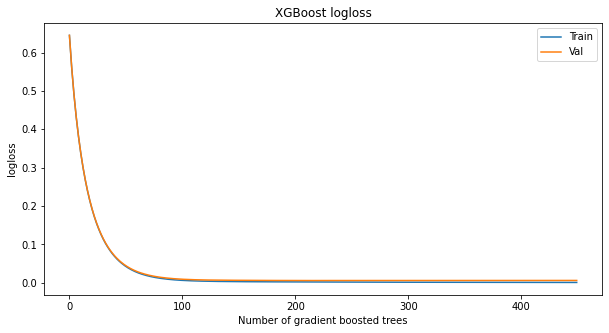

<Figure size 432x288 with 0 Axes>

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])

x_axis = range(0, epochs);
fig, ax = plt.subplots(1, 1, figsize=(10,5));
ax.plot(x_axis, results['validation_0']['logloss'], label='Train');
ax.plot(x_axis, results['validation_1']['logloss'], label='Val');
ax.legend();
ax.set_title('XGBoost logloss');
ax.set_ylabel('logloss');
ax.set_xlabel('Number of gradient boosted trees');
plt.show();
plt.tight_layout();

RMSE test: 0.036760731104690386


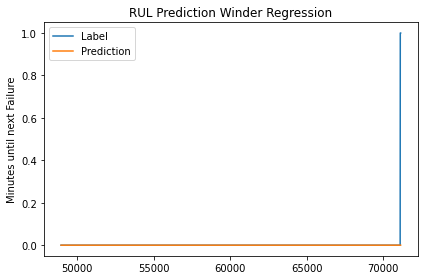

In [34]:
y_last = last_cycle["RUL"]
X_last = last_cycle.drop("RUL",axis=1)

prediction = model.predict(X_last)
prediction = prediction.flatten()
#prediction = [0 if x[0] > 0.5 else 1 for x in prediction]
print("RMSE test: {}".format(np.sqrt(mean_squared_error(y_last, prediction))))

df = pd.DataFrame({'Label': y_last, 'Prediction': prediction})

plt.plot(df['Label'], label='Label')
plt.plot(df['Prediction'], label='Prediction')
plt.ylabel("Minutes until next Failure")
plt.title("RUL Prediction Winder Regression")

plt.tight_layout()
plt.legend()
plt.savefig("rul_prediction_regr.png")
plt.show()
#for label, pred in zip(y_last, prediction):
    #print("Label: {}, Prediction: {}".format(label, pred))